Resources:
[https://pytorch.org/audio/stable/tutorials/audio_io_tutorial.html]

Install the necessary packages with:

In [84]:
!pip install -r requirements.txt

In [85]:
import torch
import torchaudio
import torchaudio.transforms as T
import matplotlib.pyplot as plt

print(torch.__version__)
print(torchaudio.__version__)

2.3.1+cu121
2.3.1+cu121


In [86]:
waveform, sample_rate = torchaudio.load('cold_cold_heart_instrumental.mp3')
print("Sample Rate = ", sample_rate)



Sample Rate =  22050


In [208]:
audio_length = waveform.shape[1] / sample_rate
print("audio length (seconds) = ", audio_length)
print("audio length (mins and secs) = ", f"{audio_length//60:.0f}", "m", f"{audio_length%60:.2f}", "s")

audio length (seconds) =  219.30009070294784
audio length (mins and secs) =  3 m 39.30 s


In [87]:
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")

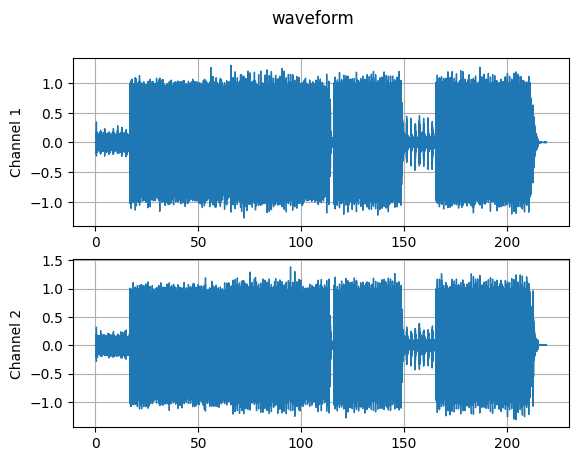

In [88]:
plot_waveform(waveform, sample_rate)

In [123]:
def plot_specgram(waveform, sample_rate, title="Spectrogram", start_time=0, end_time=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    print("Num Channels = ", num_channels)
    print("Num Frames = ", num_frames)

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        num_samples_start = sample_rate*start_time
        if end_time:
            num_samples_end = sample_rate*end_time
        else:
            num_samples_end = len(waveform[c])
        axes[c].specgram(waveform[c][num_samples_start:num_samples_end], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle(title)

Num Channels =  2
Num Frames =  4835567


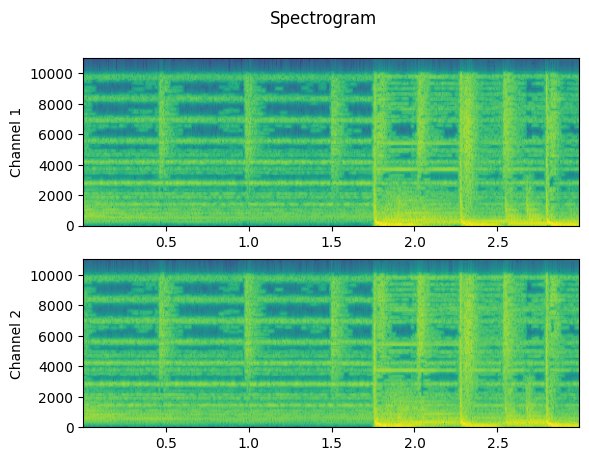

In [128]:
plot_specgram(waveform, sample_rate, start_time=15, end_time=18)

Thoughts:

Idea 1: Compute the average frequency of the whole song.  Times frames at which the average frequency is significantly lower than average are considered 'drum beats'.

Idea 2: Compute the average power of the whole song.  Time frames at higher power are 'drum beats'.

In [187]:
def compute_power(waveform, sample_rate, start_time=0, end_time=None):
    #waveform = waveform.numpy()

    spectrogram_machine = T.Spectrogram(n_fft=512)
    spec = spectrogram_machine(waveform)
    spec = spec.numpy()
    print("(Channel, freq, time) = ", spec.shape)

    power = []
    for time_index in range(len(spec[0][0][:])):
        sum = 0
        for freq_index in range(len(spec[0][:])):
            sum += spec[0][freq_index][time_index]
        power.append(sum)
    
    plt.plot(power[1250:2900])
    print(max(power))
    return power

(Channel, freq, time) =  (2, 257, 18889)
25244.389236874584


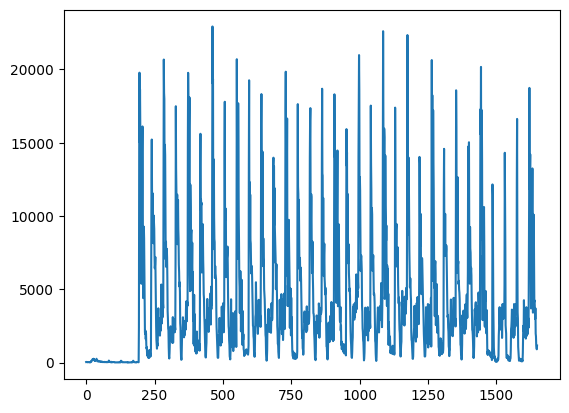

In [188]:
power = compute_power(waveform, sample_rate)

In [215]:
def detect_beats(power, audio_length):
    max_power = max(power)
    power_threshold = 0.7*max_power
    time_per_fft_frame = audio_length/len(power)
    cooldown_time = 0.75
    cooldown_frames = int(cooldown_time/time_per_fft_frame)
    print("cooldown frames = ", cooldown_frames)

    beat_times = []
    cooldown_ticker = 0

    for i in range(len(power)):
        current_time = time_per_fft_frame * i

        if cooldown_ticker > 0:
            cooldown_ticker -= 1

        if power[i]>power_threshold and cooldown_ticker==0:
            beat_times.append(current_time)
            cooldown_ticker = cooldown_frames

    print(beat_times)
    return beat_times

In [216]:
detect_beats(power, audio_length)

cooldown frames =  86
[16.77635825431519, 17.80964260354291, 18.842926952770625, 19.876211301998342, 20.909495651226063, 21.954389936961956, 22.987674286189673, 24.53179584177716, 26.087527333872828, 27.120811683100545, 28.154096032328262, 29.18738038155598, 30.220664730783696, 31.27716895302777, 33.33212771497502, 34.37702200071092, 35.398696413430464, 36.43198076265818, 37.4652651118859, 38.49854946111361, 39.53183381034133, 40.56511815956905, 41.610012445304946, 42.65490673104084, 43.67658114376038, 44.709865492988094, 45.743149842215814, 46.776434191443535, 47.80971854067125, 48.84300288989897, 49.89950711214304, 50.932791461370755, 51.942855937582124, 52.98775022331802, 55.05431892177345, 56.08760327100117, 57.120887620228885, 58.154171969456605, 59.1990662551925, 60.22074066791204, 61.25402501713975, 67.46534104901424, 68.49862539824196, 69.53190974746967, 70.5651940966974, 71.61008838243329, 72.643372731661, 73.6882670173969, 74.70994143011644, 75.74322577934416, 76.776510128571

[16.77635825431519,
 17.80964260354291,
 18.842926952770625,
 19.876211301998342,
 20.909495651226063,
 21.954389936961956,
 22.987674286189673,
 24.53179584177716,
 26.087527333872828,
 27.120811683100545,
 28.154096032328262,
 29.18738038155598,
 30.220664730783696,
 31.27716895302777,
 33.33212771497502,
 34.37702200071092,
 35.398696413430464,
 36.43198076265818,
 37.4652651118859,
 38.49854946111361,
 39.53183381034133,
 40.56511815956905,
 41.610012445304946,
 42.65490673104084,
 43.67658114376038,
 44.709865492988094,
 45.743149842215814,
 46.776434191443535,
 47.80971854067125,
 48.84300288989897,
 49.89950711214304,
 50.932791461370755,
 51.942855937582124,
 52.98775022331802,
 55.05431892177345,
 56.08760327100117,
 57.120887620228885,
 58.154171969456605,
 59.1990662551925,
 60.22074066791204,
 61.25402501713975,
 67.46534104901424,
 68.49862539824196,
 69.53190974746967,
 70.5651940966974,
 71.61008838243329,
 72.643372731661,
 73.6882670173969,
 74.70994143011644,
 75.7432